In [108]:
import sys,os,glob,copy
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']


pd.set_option('display.max_rows', 200)

### Load CMS data

In [109]:
# ### Load CMS data
cmsYieldFile = './CMS_data/HEPData-ins1894408-v2-csv/Simplifiedlikelihood:Yields(Monojet).csv'
bgYields = np.genfromtxt(cmsYieldFile,delimiter=',',skip_header=5,
                        skip_footer=67,names=True,dtype=None,encoding=None)

dataYields = np.genfromtxt(cmsYieldFile,delimiter=',',skip_header=73,
                        names=True,dtype=None,encoding=None)


### Add recast samples

In [110]:
file = './results_dataFrames/pp2BB_monojet.pcl'
recastData = pd.read_pickle(file)
recastData.sort_values(['$m_{Y}$','$m_{\tilde \chi_1^0}$','Data-takingperiod'],inplace=True,
              ascending=[True,True,True])    

In [111]:
dataYields.dtype

dtype([('Bin', '<U18'), ('Data_yield', '<i8')])

### Select model and data

In [112]:
modelFilter = {'$m_{Y}$' : 500.0,
 '$m_{\tilde \chi_1^0}$' : 475.0,
 'Data-takingperiod' : 2017}

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in modelFilter.items()])
dfModel = recastData.loc[(recastData[list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]
textstr = textstr.replace('\t','\\t')
nbg = []
nobs = []
for ibin in range(22):
    binLabel = 'monojet_%i_bin%i' %(modelFilter['Data-takingperiod'],ibin)
    nbg.append(eval(bgYields[bgYields['Bin'] == binLabel]['Background_yield'][0]))
    nobs.append(eval(str(dataYields[dataYields['Bin'] == binLabel]['Data_yield'][0])))
# nbg  = [(pt['Bin'],eval(pt['Background_yield'])) for pt in bgYields if int(pt['Bin'].split('_')[1]) == modelFilter['Data-takingperiod']]
# nbg = sorted(nbg)
# nbg = [x[1] for x in nbg[:]]

# nobs  = [(pt['Bin'],eval(str(pt['Data_yield']))) for pt in dataYields if int(pt['Bin'].split('_')[1]) == modelFilter['Data-takingperiod']]
# nobs = sorted(nobs)
# nobs = [x[1] for x in nobs[:]]

### Aux functions for plotting

In [113]:
def getBins(dfModel,rightBin = 2000.):
    
    bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and not 'Error' in c)}
    binsError = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and 'ErrorPlus' in c)}    
    binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()    
    binLeft = [bins[c] for c in bins]+[rightBin] 
    
    return bins,binsError,binCenter,binLeft
    
def getMETbins(dfSingle,bins,binsError):

    data = {c : dfSingle[c].iloc[0] for c in bins}
    dataError = {c : dfSingle[c].iloc[0] for c in binsError}

    return data,dataError


### Plot MET bins

In [114]:
bins,binsError,binCenter,binLeft = getBins(dfModel)

In [115]:
colors = sns.color_palette('Paired')

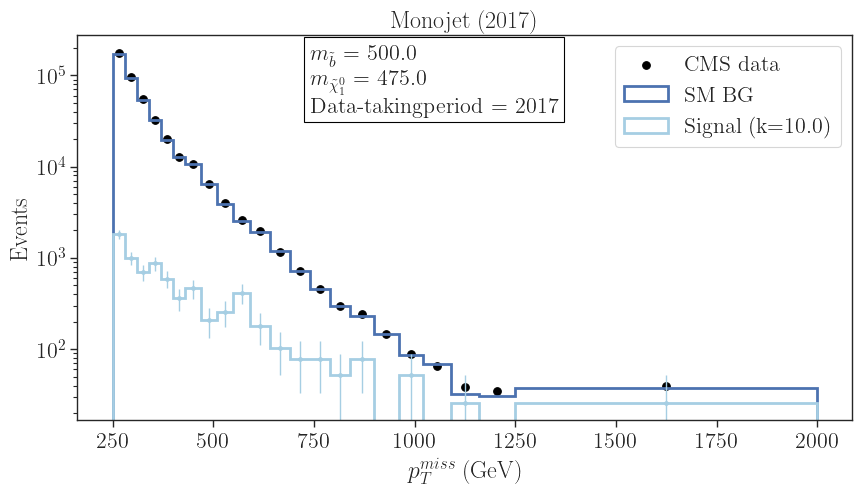

In [116]:
kfactor = 10.0

f, axarr = plt.subplots(1,sharex=True,figsize=(10,5))
# plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)
axarr = [axarr]
axarr[0].scatter(x=binCenter,y=nobs,s=30,label='CMS data',color='black')
axarr[0].hist(binCenter,bins=binLeft,linewidth=2,
                        weights=nbg,histtype='step',label='SM BG')

d,dError = getMETbins(dfModel,bins,binsError)
weights = kfactor*np.array([d[c] for c in bins])
error = kfactor*np.array([dError[c] for c in binsError]) 
axarr[0].hist(binCenter,bins=binLeft,linewidth=2,color=colors[0],
                        weights=weights,histtype='step',label='Signal (k=%1.1f)' %kfactor)
axarr[0].errorbar(binCenter,weights,yerr = error, marker = '.', color=colors[0],elinewidth=1.0, drawstyle = 'steps-mid',linewidth=0.0)


axarr[0].set_xlabel(r'$p_{T}^{miss}$ (GeV)')
axarr[0].set_yscale('log')
axarr[0].set_ylabel('Events')
axarr[0].legend()

axarr[0].text(0.3,0.8,r'%s'%textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
        transform = plt.gca().transAxes)

# axarr[0].set_ylim(1e-2,1e3)
# axarr[0].set_xlim(250,1000)
# axarr[1].set_ylim(0.5,1.5)
axarr[0].set_title('Monojet (%s)' %dfModel['Data-takingperiod'].unique()[0])
plt.show()
